# Solving Krussel-Smith with Deep Equilibrium Nets
*Simon Lebastard, 02/07/2023*

## Krussel-Smith (1998) model
In the KS'98 model, we look a flavour of the stochastic growth model with a continuum of households under partially uninsurable risk.

**Demand side**
$$V(c) = \mathrm{E}_0\Big[\sum_{t=0}^{\infty}{\beta^t U(c_t)}\Big]$$
with
$$U(c) = \lim_{\nu \to \sigma}{\frac{c^{1-\nu} - 1}{1 - \nu}}$$

Agents are each endowed with $\epsilon \tilde{l}$ units of labor per period, where $\epsilon$ is a first-order Markov chain. (In K&S'98, $\epsilon$ can only take two values: 0 and 1, representing unemployed and employed idiosyncratic states, respectively).
As a very large number of agents is consided, and by assumed independence of the idiosyncratic shocks, K&S'98 assume that the total number of employed and unemployed people remain constant over time. That is, there is no aggregate fluctuations of jobs supply.

Idiosyncratic endogenous state: $k$ holding of capital
Idiosyncratic exogenous state: $\epsilon$ at the individual level
$\Gamma$ the joint distribution of idiosyncratic states $(k,\epsilon)$

Given the aggregate states (see $z$ defined below), the consumer's optimization problem is:
$$v(k,\epsilon;\Gamma,z) = \max_{c,k'}{ \Big\{ U(c) + \beta\mathrm{E}\Big[v(k',\epsilon';\Gamma',z') \mid z,\epsilon \Big] \Big\} } $$
under budget constraint, rational expectations wrt law of motion and non-negative capital holding.

The budget constraint writes:
$$c+k' = r(\hat{k},\hat{l},z)k + w(\hat{k},\hat{l},z)\tilde{l}\epsilon + (1-\delta)k$$

**Supply side**
A single-type good is produced using two factors of production: labor $l$ and capital $k$.
The good is produced according to a Cobb-Douglas production function:
$$y = zk^{\alpha}l^{1-\alpha}, \quad \alpha \in [0,1]$$
The TFP is stochastic and coresponds to the source of aggregate risk. In K&S'98, two aggregate states are considered: $(z_b, z_g)$.
Again, $z$ follows a first-order Markov chain.

We assume the production market to be competitive, such that wages $w$ and rental rates $r$, both functions of aggregate states, are respectively determined by:
$$w(\hat{k},\hat{l},z) = (1 - \alpha)z(\frac{\hat{k}}{\hat{l}})^\alpha$$
$$r(\hat{k},\hat{l},z) = \alpha z(\frac{\hat{k}}{\hat{l}})^{\alpha-1}$$

Here we assume that as the population of households is infinitely large, the share of unemployed remains constant. Moreover, here consumers have no disutility from labor, implying that the labor supply at each period is constant at $L_s = N*\mathrm{E}\big[\epsilon\big]$.
We have the market clearing condition for the capital/cons good: $$\int{(c(k,\epsilon;\Gamma,z) + k'(k,\epsilon;\Gamma,z))dF(\Gamma)} = (1-\delta)\int{k dF(\Gamma)} + z\int{k dF(\Gamma)}^{\alpha}L_s^{1-\alpha}$$

For both Markov chains, we assume the economy is already running at the stationary distribution.

**Law of motion**
$$\Gamma' = H(\Gamma,z,z')$$


### Formulating the problem for solving with DEN
Here we will consider two "implicit" policy functions for which we solve:
- Next-period capital $k'(k,\epsilon;\Gamma,z)$
- The Lagrange multiplier on the next-period capital non-negativity constraint: $\mu_k(k,\epsilon;\Gamma,z)$
- The Lagrange multiplier on the positivity of current-period consumption, ie of the residual of the budget constraint: $\mu_c(k,\epsilon;\Gamma,z)$

As in Azinovic et al, we simulate $N$ agents, and index $i \in [1,...,N]$.

#### Idiosyncratic error terms
The Euler equation can be obtained by taking the FOC of the consumer's objective function with respect to next-period capital:
$$1 = \beta(1-\delta)\mathrm{E}\Big[\Big(\frac{c(k,\epsilon;\Gamma,z)}{c(k',\epsilon';\Gamma',z')}\Big)^{\nu} \mid z,\epsilon\Big] - \big(\mu_c(k,\epsilon;\Gamma,z) - \mu_k(k,\epsilon;\Gamma,z) \big)c(k,\epsilon;\Gamma,z)^{\nu}$$

Based on that, we defined the Euler error as:
$$e_{EE}(k,\epsilon,\Gamma,z) \equiv \bigg[\beta(1-\delta)\mathrm{E}\Big[\Big(\frac{c(k,\epsilon;\Gamma,z)}{c(k',\epsilon';\Gamma',z')}\Big)^{\nu} \mid z,\epsilon\Big] - \big(\mu_c(k,\epsilon;\Gamma,z) - \mu_k(k,\epsilon;\Gamma,z) \big)\bigg]^{-\frac{1}{\nu}} - 1$$
and
$$e_{EE,i} \equiv e_{EE}(k_i,\epsilon_i,\Gamma,z)$$
Here we want to train the model to capture binding constraints by itself. Note that in practice, during training we may end up with negative consumptions (that will be penalized), such that ratio $\frac{c(k,\epsilon;\Gamma,z)}{c(k',\epsilon';\Gamma',z')}^\nu$ may not be defined for $\nu \in \mathbb{R}$.
To solve this issue, I use RELU activation in the last two layers of the network, to enforce $c(k,\epsilon;\Gamma,z), k'(k,\epsilon;\Gamma,z), \mu_c(k,\epsilon;\Gamma,z), \mu_k(k,\epsilon;\Gamma,z)$ to be non-negative for all states.

We define the error on the complementary-slackness condition on k as:
$$e_{CS_k}(k,\epsilon,\Gamma,z) \equiv \frac{\mu_k(k,\epsilon;\Gamma,z)}{U'(\bar{c})} \frac{k'(k,\epsilon;\Gamma,z)}{\bar{k}}$$
and
$$e_{CS_k,i} \equiv e_{CS_k}(k_i,\epsilon_i,\Gamma,z)$$

We define the error on the complementary-slackness condition on c as:
$$e_{CS_c}(k,\epsilon,\Gamma,z) \equiv \frac{\mu_c(k,\epsilon;\Gamma,z)}{U'(\bar{c})} \frac{c(k,\epsilon;\Gamma,z)}{\bar{c}}$$
and
$$e_{CS_c,i} \equiv e_{CS_c}(k_i,\epsilon_i,\Gamma,z)$$

The agent's budget constraint is:
$$e_{BC}(k,\epsilon,\Gamma,z) \equiv \frac{1}{\hat{c}+\hat{k}}\bigg[ c + k' - \big( 1 + r(\hat{k}, \hat{l}, z) - \delta \big)k - w(\hat{k}, \hat{l}, z)\tilde{l}\epsilon \bigg] $$

#### Aggregate error term
At each period, we compute the aggregate $K \equiv \sum_{i=1}^{N}{k_i}$

One way to proceed could be to define an error based on the market clearing condition on capital. Instead, we will enforce consumption to satisfy the market clearing condition at each period. Note that in doing so, we could still need to enforce that consumption is positive. Instead of enforcing a new constraint on a Lagrangian multiplier associated with consumption, I compute the error on MC by constraining consumption to be positive in the error, by using a transformation of the error that satisfies:
$$\lim_{c \downarrow 0}{e_{MC}(c)} = \infty$$
This should prevent consumption from ever being non-positive.

We define the error on the market clearing condition as:
$$e_{MC} \equiv \sum_{i=1}^{N}{\Big[c(k_i,\epsilon_i;\Gamma,z) + k'(k_i,\epsilon_i;\Gamma,z)\Big]} - zK^{\alpha}(Nu)^{1-\alpha} - (1-\delta)K$$

We also define the error on the aggregate law of motion as:
$$e_{LM} \equiv $$

#### Defining the loss function
On a batch $\mathcal{D}_{train}$, the loss function is defined as:
$$l(\theta) \equiv \frac{1}{\mid\mathcal{D}_{train}\mid} \sum_{x \in \mathcal{D}_{train}}{\frac{1}{N-1}\sum_{i=1}^{N}{\Big(e_{EE,i}^2 + e_{CS_k,i}^2 + e_{CS_c,i}^2\Big)} + e_{MC}^2}$$

**Note: alternative implementation**<br>
Instead of having a policy variable for the Lagrange multiplier on the positivity of next-period capital, we could have a transformation function on  next-period capital that ensures it remains non-negative at all times. I will implement this alternative method and compare results.

#### Network architecture
The network architecture is composite, with one subnetwork tasked with learning a useful representation of the distribution of capital holdings, and a second agent-network tasked with learning agent's policy on next-period capital and consumption.

**Distribution representation network**
- $1+N$ scalar inputs: $(z, \big\{k_i\big\}_{i \in [1..N]})$
- $n_{repr,distr}$ scalar outputs

**Policy network**
- $n_{repr,distr} + 2$ scalar inputs, with agent-specific inputs being $(\epsilon_i, k_i)$
- 4 scalar outputs: $(k_i', {\mu_{k}}_i, c_i, {\mu_{c}}_i)$

In [1]:
# Import modules
import os
import re
from datetime import datetime

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Model
from keras.layers import * #Input, Dense, BatchNormalization
from tensorflow import Tensor

# Set the seed for replicable results
seed = 0
np.random.seed(seed)
#tf.set_random_seed(seed)

2023-02-10 16:54:05.533857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def firm(K:Tensor, z:Tensor):
    prod = z*tf.pow(K, α)*tf.pow(L, 1-α)
    r = z*α*tf.pow(K, α-1)*tf.pow(L, 1-α)
    w = z*(1-α)*tf.pow(K, α)*tf.pow(L, -α)
    return prod, r, w

In [3]:
from tensorflow.random import stateless_binomial

# Shocks structure
Z = tf.constant([0.9, 1.1], dtype=tf.float32)
z_l = Z[0]
z_h = Z[1]
P_z = tf.constant([[0.9, 0.1], [0.1, 0.9]], dtype=tf.float32)
def draw_z(z):
    z_id = int(z==z_h)
    zp_id = stateless_binomial(shape=[1], seed=[123, 456], counts=[1.], probs=[P_z[z_id,1]])[0]
    return Z[zp_id]

E = tf.constant([0, 1], dtype=tf.float32)
eps_l = E[0]
eps_h = E[1]
P_eps = tf.constant([[0.5, 0.5], [0.5, 0.5]], dtype=tf.float32)
def draw_eps(N: int):
    return stateless_binomial(
        shape=[N,],
        seed=[123, 456],
        counts=1,
        probs=0.5,
        output_dtype=tf.float32,
    )

# Other constants
α = tf.constant(0.3, dtype=tf.float32)
β = tf.constant(0.7, dtype=tf.float32)
δ = tf.constant(0.1, dtype=tf.float32)
γ = tf.constant(2.0, dtype=tf.float32)

2023-02-10 16:54:10.102653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Neural Network - Architecture

The following is a specialization class of Keras' Model, with a custom training step with gradient taping

In [18]:
@tf.function
def budget_residual(k: Tensor, c: Tensor, eps:Tensor, kp: Tensor, r:float, w:float):
    return w*eps + (1+r-δ)*k - kp - c

@tf.function
def FB(a:float, b:float):
    return a + b - tf.sqrt(tf.pow(a,2) + tf.pow(b,2))

class DENModel(Model):

    @tf.function
    def __init__(self, inputs, *args, **kwargs):
        self.N = inputs[0].shape[1] - 1
        super().__init__(inputs, *args, **kwargs)

    @tf.function
    def initialize_k(self):
        k_ss = 2.
        return tf.Variable(tf.random.uniform(shape=[self.N,], minval=0.8*k_ss, maxval=1.2*k_ss))

    @tf.function
    def _forward_DEPRECATED(self, z:Tensor, k:Tensor, eps:Tensor, training:bool=False):
        kp = tf.Variable(tf.zeros_like(k))
        mup = tf.Variable(tf.zeros_like(k))
        c = tf.Variable(tf.zeros_like(k))
        lambdap = tf.Variable(tf.zeros_like(k))

        x_aggr = tf.concat([z[None],k],axis=0)
        x_aggr = tf.reshape(x_aggr, shape=[1,-1])
        for agent_id in range(self.N):
            x_idio = tf.concat([k[agent_id][None], eps[agent_id][None]], axis=0)
            x_idio = tf.reshape(x_idio, shape=[1,-1])
            pol = self(inputs=(x_aggr, x_idio), training=training)
            kp[agent_id].assign(pol[0,0])
            mup[agent_id].assign(pol[0,1])
            c[agent_id].assign(pol[0,2])
            lambdap[agent_id].assign(pol[0,3])
        return kp, mup, c, lambdap

    @tf.function
    def forward(self, z:Tensor, k:Tensor, eps:Tensor, training:bool=False):
        x_aggr = tf.concat([z[None],k],axis=0)
        x_aggr = tf.tile(tf.reshape(x_aggr, shape=[1,-1]), tf.constant([self.N,1], tf.int32))
        
        x_idio = tf.concat([tf.reshape(k,[-1,1]),tf.reshape(eps,[-1,1])],axis=1)
        y = self(inputs=(x_aggr, x_idio), training=training)
        return y

    @tf.function
    def residuals(self, z:Tensor, k:Tensor, eps:Tensor):
        K = tf.math.reduce_sum(k)
        if K<0:
            print("K: NEGATIVE AGGREGATE CAPITAL DESPITE RELU!!")
        Y,r,w = firm(K,z)
        #print("CURRENT-PERIOD AGGREGATE CAPITAL")
        #print(K)
        #print("CURRENT-PERIOD PRODUCTION, ROC, WAGE")
        #print(Y,r,w)

        # 1st forward pass
        yp = self.forward(z, k, eps, training=True)
        kp = yp[:,0]
        mup = yp[:,1]
        c = yp[:,2]
        lambdap = yp[:,3]
        C = tf.math.reduce_sum(c)
        Kp = tf.math.reduce_sum(kp)
        if Kp<0:
            print("Kp: NEGATIVE AGGREGATE CAPITAL DESPITE RELU!!")
        BUDGET_RES = budget_residual(k, c, eps, kp, r, w)
        CSK_RES = mup*kp
        CSC_RES = c*lambdap

        # For each possible value of next-period exogenous states, compute the next-period policy
        kpp = tf.Variable(tf.zeros((self.N,2)))
        Kpp = tf.Variable(tf.zeros((2,)))
        mupp = tf.Variable(tf.zeros((self.N,2)))
        lambdapp = tf.Variable(tf.zeros((self.N,2)))
        cp = tf.Variable(tf.zeros((self.N,2)))
        Cp = tf.Variable(tf.zeros((2,)))
        ee_comp = tf.Variable(tf.zeros((self.N,2)))
        # BUDGET_RES_COND = np.zeros((N,2))
        # CSK_RES_COND = np.zeros((N,2))
        # CSC_RES_COND = np.zeros((N,2))
        # MC_RES_COND = np.zeros((N,2))

        for zp_id, zp in enumerate(Z):
            Yp,rp,wp = firm(Kp,zp)
            epsp = draw_eps(self.N)
            ypp = self.forward(zp, kp, epsp, training=True)
            kpp[:,zp_id].assign(ypp[:,0])
            mupp[:,zp_id].assign(ypp[:,1])
            cp[:,zp_id].assign(ypp[:,2])
            lambdapp[:,zp_id].assign(ypp[:,3])
            ee_comp_tmp = tf.pow(c/cp[:,zp_id],γ)
            ee_comp[:,zp_id].assign(tf.where(tf.math.is_nan(ee_comp_tmp), 1e6*tf.ones_like(ee_comp_tmp), ee_comp_tmp))
            # BUDGET_RES_COND[:,zp_id] = budget_residual(kp, ypp[2], epsp, ypp[0], rp, wp)
            # CSK_RES_COND[:,zp_id] = mupp[:,zp_id]*kpp[:,zp_id]
            # CSC_RES_COND[:,zp_id] = cp[:,zp_id]*lambdapp[:,zp_id]

            Kpp[zp_id].assign(tf.math.reduce_sum(kpp[:,zp_id]))
            if Kpp[zp_id]<0:
                print("Kpp[{0:d}]: NEGATIVE AGGREGATE CAPITAL DESPITE RELU!!".format(zp_id))
            Cp[zp_id].assign(tf.math.reduce_sum(cp[:,zp_id]))
            # MC_RES_COND[zp_id] = Cp[zp_id] + Kpp[zp_id] - (1-δ)*Kp - Yp
        
        EE_RES = tf.pow(
            β*(1-δ)*tf.tensordot(ee_comp,tf.transpose(P_z[int(z==z_h),:]), axes=1) - (lambdap - mup),
            -1./γ
        ) - 1
        
        MC_RES = C + Kp - (1-δ)*K - Y
        return BUDGET_RES, CSK_RES, CSC_RES, MC_RES

    @tf.function
    def train_step(self, data, batch_size):
        z, k, eps = data
        ERR = 0
        for per_id in range(batch_size):
            y = self.forward(z, k, eps, training=False)
            BUDGET_RES, CSK_RES, CSC_RES, MC_RES = self.residuals(z, k, eps)
            # print("BUDGET RESIDUAL: ", BUDGET_RES*BUDGET_RES)
            # print("CS on K: ", CSK_RES*CSK_RES)
            # print("CS on C: ", CSC_RES*CSC_RES)
            # print("MK: ", MC_RES*MC_RES)
            # print("TOTAL ERROR FORM IS SOURCES: ", tf.math.reduce_mean(BUDGET_RES*BUDGET_RES + CSK_RES*CSK_RES + CSC_RES*CSC_RES))
            ERR += (1./batch_size)*tf.math.reduce_mean(BUDGET_RES*BUDGET_RES + CSK_RES*CSK_RES + CSC_RES*CSC_RES) + MC_RES*MC_RES
            k = y[:,0]
            eps = draw_eps(self.N)
            z = draw_z(z)
        return ERR, z, k, eps
    
    @tf.function
    def train(self, optimizer, n_epochs=1000, batch_size: int=64):
        z = z_h
        eps = draw_eps(self.N)
        k = self.initialize_k()
        metrics = {'mse': []}

        for epoch in tqdm(range(n_epochs)):
            with tf.GradientTape() as tape:
                ERR, z, k, eps = self.train_step([z, k, eps], batch_size)
            grads = tape.gradient(ERR, self.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.trainable_weights))
            metrics['mse'].append(ERR.numpy())

            # Log every 200 batches.
            if epoch % 10 == 0:
                print(
                    "Training loss (for one batch) at epoch %d: %.4f"
                    % (epoch, float(ERR))
                )
                print("Total # time iterations: %d" % (batch_size*(1+epoch)))
            
        return metrics
    
lr = 0.00001
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
)

### Compact network approach

In [19]:
N = num_agents = 500
L = N*tf.reduce_mean(E)
n_aggr_repr = 8

initializer = tf.keras.initializers.GlorotUniform()

## AGGREGATE REPRESENTATION UNITS
# Common network processes distribution-relevant information
x_aggr = Input(shape=(N+1, ), name='Distr-In')
#xn_aggr = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,)(x_aggr)
aggr_1 = Dense(units=4*n_aggr_repr, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense1')(x_aggr)
aggr_2 = Dense(units=4*n_aggr_repr, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense2')(aggr_1)
aggr_3 = Dense(units=2*n_aggr_repr, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense3')(aggr_2)
aggr_4 = Dense(units=n_aggr_repr, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense4')(aggr_3)

## POLICY UNITS
# Agent-specific policy units
x_idio = Input(shape = (2, ), name='Idio-In')
combined = Concatenate(name='Intermediate_Input')([aggr_4, x_idio])
interp_c_h_1 = Dense(units=32, input_dim=2+n_aggr_repr, activation = 'tanh', kernel_initializer=initializer, name='Policy-Dense1')(combined)
interp_c_h_2 = Dense(units=32, activation = 'tanh', kernel_initializer=initializer, name='Policy-Dense2')(interp_c_h_1)
interp_c_h_3 = Dense(units=32, activation = 'relu', kernel_initializer=initializer, name='Policy-Relu1')(interp_c_h_2)
policy = Dense(units=4, activation = 'relu', kernel_initializer=initializer, name='Policy-Relu2')(interp_c_h_3)

model = DENModel(inputs = [x_aggr,x_idio], outputs= policy)

/Users/slebst/opt/miniconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [20]:
model.summary()

Model: "den_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Distr-In (InputLayer)          [(None, 501)]        0           []                               
                                                                                                  
 Distr-Dense1 (Dense)           (None, 32)           16064       ['Distr-In[0][0]']               
                                                                                                  
 Distr-Dense2 (Dense)           (None, 32)           1056        ['Distr-Dense1[0][0]']           
                                                                                                  
 Distr-Dense3 (Dense)           (None, 16)           528         ['Distr-Dense2[0][0]']           
                                                                                        

### Brute-force MC-Distribution-processing neural network

In [21]:
# n_aggr_reprb = 8

## AGGREGATE REPRESENTATION UNITS
## Common network processes distribution-relevant information
# x_aggrb = Input(shape = (None,2))
# xn_aggrb = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,)(x_aggr)
# aggr_1b = Dense(4*n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(xn_aggr)
# aggr_2b = Dense(4*n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(aggr_1)
# aggr_3b = Dense(2*n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(aggr_2)
# aggr_4b = Dense(n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(aggr_3)

## POLICY UNITS
# Agent-specific policy units
# x_idiob = Input(shape = (None,2*N))
# interp_c_h_1b = Dense(32, input_dim=2*N+n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(tf.concat(values=(x_idiob,aggr_4b),axis=1))
# interp_c_h_2b = Dense(32, activation = 'tanh', kernel_initializer=initializer)(interp_c_h_1b)
# policyb = Dense(2*N, activation = 'tanh', kernel_initializer=initializer)(interp_c_h_2b)

# nn2 = DENModel(inputs = tf.concat(values=(x_aggrb,x_idiob)), outputs= policyb)

### Model training

In [22]:
k = model.initialize_k()
eps = draw_eps(N)

In [23]:
yp = model.forward(z_h, k, eps)

In [24]:
RES = model.residuals(z_h, k, eps)

In [25]:
BUDGET_RES, CSK_RES, CSC_RES, MC_RES = RES

In [26]:
tf.math.reduce_mean(BUDGET_RES*BUDGET_RES + CSK_RES*CSK_RES + CSC_RES*CSC_RES) + MC_RES*MC_RES

<tf.Tensor: shape=(), dtype=float32, numpy=1032903.3>

In [27]:
ERR, z, k, eps = model.train_step([z_h,k,eps], batch_size=3)

In [28]:
ERR

<tf.Tensor: shape=(), dtype=float32, numpy=1117607.4>

Training time!

In [33]:
metrics = model.train(optimizer=optimizer, n_epochs=1000, batch_size=16)

  0%|          | 1/1000 [00:01<19:25,  1.17s/it]

Training loss (for one batch) at epoch 0: 1089929.2500
Total # time iterations: 16


  1%|          | 11/1000 [00:11<15:34,  1.06it/s]

Training loss (for one batch) at epoch 10: 42896.0000
Total # time iterations: 176


  2%|▏         | 21/1000 [00:20<16:28,  1.01s/it]

Training loss (for one batch) at epoch 20: 37447.3281
Total # time iterations: 336


  3%|▎         | 31/1000 [00:29<14:31,  1.11it/s]

Training loss (for one batch) at epoch 30: 32227.4961
Total # time iterations: 496


  4%|▍         | 41/1000 [00:39<15:32,  1.03it/s]

Training loss (for one batch) at epoch 40: 27546.9707
Total # time iterations: 656


  5%|▌         | 51/1000 [00:48<14:30,  1.09it/s]

Training loss (for one batch) at epoch 50: 23409.6289
Total # time iterations: 816


  6%|▌         | 61/1000 [00:58<14:53,  1.05it/s]

Training loss (for one batch) at epoch 60: 19754.5059
Total # time iterations: 976


  7%|▋         | 71/1000 [01:08<15:50,  1.02s/it]

Training loss (for one batch) at epoch 70: 16507.7969
Total # time iterations: 1136


  8%|▊         | 81/1000 [01:18<13:54,  1.10it/s]

Training loss (for one batch) at epoch 80: 13612.5029
Total # time iterations: 1296


  9%|▉         | 91/1000 [01:27<13:13,  1.15it/s]

Training loss (for one batch) at epoch 90: 11014.6240
Total # time iterations: 1456


 10%|█         | 101/1000 [01:36<14:06,  1.06it/s]

Training loss (for one batch) at epoch 100: 8667.4814
Total # time iterations: 1616


 11%|█         | 111/1000 [01:45<13:44,  1.08it/s]

Training loss (for one batch) at epoch 110: 6535.6870
Total # time iterations: 1776


 12%|█▏        | 121/1000 [01:54<13:23,  1.09it/s]

Training loss (for one batch) at epoch 120: 4601.3340
Total # time iterations: 1936


 13%|█▎        | 131/1000 [02:03<13:28,  1.07it/s]

Training loss (for one batch) at epoch 130: 2877.6765
Total # time iterations: 2096


 14%|█▍        | 141/1000 [02:15<19:00,  1.33s/it]

Training loss (for one batch) at epoch 140: 1403.0759
Total # time iterations: 2256


 15%|█▌        | 151/1000 [02:25<13:11,  1.07it/s]

Training loss (for one batch) at epoch 150: 379.7571
Total # time iterations: 2416


 16%|█▌        | 161/1000 [02:33<12:30,  1.12it/s]

Training loss (for one batch) at epoch 160: 7.6896
Total # time iterations: 2576


 17%|█▋        | 171/1000 [02:42<11:55,  1.16it/s]

Training loss (for one batch) at epoch 170: 32.9961
Total # time iterations: 2736


 18%|█▊        | 181/1000 [02:51<11:53,  1.15it/s]

Training loss (for one batch) at epoch 180: 17.9024
Total # time iterations: 2896


 19%|█▉        | 191/1000 [03:00<12:24,  1.09it/s]

Training loss (for one batch) at epoch 190: 0.2012
Total # time iterations: 3056


 20%|██        | 201/1000 [03:10<12:37,  1.05it/s]

Training loss (for one batch) at epoch 200: 1.4242
Total # time iterations: 3216


 21%|██        | 211/1000 [03:20<12:26,  1.06it/s]

Training loss (for one batch) at epoch 210: 0.7955
Total # time iterations: 3376


 22%|██▏       | 221/1000 [03:29<11:44,  1.11it/s]

Training loss (for one batch) at epoch 220: 0.0210
Total # time iterations: 3536


 23%|██▎       | 231/1000 [03:38<11:52,  1.08it/s]

Training loss (for one batch) at epoch 230: 0.0657
Total # time iterations: 3696


 24%|██▍       | 241/1000 [03:46<11:02,  1.15it/s]

Training loss (for one batch) at epoch 240: 0.0385
Total # time iterations: 3856


 25%|██▌       | 251/1000 [03:56<11:41,  1.07it/s]

Training loss (for one batch) at epoch 250: 0.0067
Total # time iterations: 4016


 26%|██▌       | 261/1000 [04:04<10:40,  1.15it/s]

Training loss (for one batch) at epoch 260: 0.0093
Total # time iterations: 4176


 27%|██▋       | 271/1000 [04:13<10:56,  1.11it/s]

Training loss (for one batch) at epoch 270: 0.0079
Total # time iterations: 4336


 28%|██▊       | 281/1000 [04:23<11:31,  1.04it/s]

Training loss (for one batch) at epoch 280: 0.0066
Total # time iterations: 4496


 29%|██▉       | 291/1000 [04:31<10:31,  1.12it/s]

Training loss (for one batch) at epoch 290: 0.0066
Total # time iterations: 4656


 30%|███       | 301/1000 [04:40<10:12,  1.14it/s]

Training loss (for one batch) at epoch 300: 0.0066
Total # time iterations: 4816


 31%|███       | 311/1000 [04:49<11:00,  1.04it/s]

Training loss (for one batch) at epoch 310: 0.0065
Total # time iterations: 4976


 32%|███▏      | 321/1000 [04:58<10:22,  1.09it/s]

Training loss (for one batch) at epoch 320: 0.0065
Total # time iterations: 5136


 33%|███▎      | 331/1000 [05:07<10:02,  1.11it/s]

Training loss (for one batch) at epoch 330: 0.0065
Total # time iterations: 5296


 34%|███▍      | 341/1000 [05:16<09:42,  1.13it/s]

Training loss (for one batch) at epoch 340: 0.0065
Total # time iterations: 5456


 35%|███▌      | 351/1000 [05:25<09:38,  1.12it/s]

Training loss (for one batch) at epoch 350: 0.0065
Total # time iterations: 5616


 36%|███▌      | 361/1000 [05:34<09:36,  1.11it/s]

Training loss (for one batch) at epoch 360: 0.0065
Total # time iterations: 5776


 37%|███▋      | 371/1000 [05:43<09:14,  1.13it/s]

Training loss (for one batch) at epoch 370: 0.0065
Total # time iterations: 5936


 38%|███▊      | 381/1000 [05:52<08:58,  1.15it/s]

Training loss (for one batch) at epoch 380: 0.0065
Total # time iterations: 6096


 39%|███▉      | 391/1000 [06:01<09:25,  1.08it/s]

Training loss (for one batch) at epoch 390: 0.0065
Total # time iterations: 6256


 40%|████      | 401/1000 [06:10<09:04,  1.10it/s]

Training loss (for one batch) at epoch 400: 0.0065
Total # time iterations: 6416


 41%|████      | 411/1000 [06:20<08:56,  1.10it/s]

Training loss (for one batch) at epoch 410: 0.0065
Total # time iterations: 6576


 42%|████▏     | 421/1000 [06:28<08:35,  1.12it/s]

Training loss (for one batch) at epoch 420: 0.0065
Total # time iterations: 6736


 43%|████▎     | 431/1000 [06:37<08:31,  1.11it/s]

Training loss (for one batch) at epoch 430: 0.0065
Total # time iterations: 6896


 44%|████▍     | 441/1000 [06:46<08:28,  1.10it/s]

Training loss (for one batch) at epoch 440: 0.0065
Total # time iterations: 7056


 45%|████▌     | 451/1000 [06:56<08:28,  1.08it/s]

Training loss (for one batch) at epoch 450: 0.0065
Total # time iterations: 7216


 46%|████▌     | 461/1000 [07:05<08:15,  1.09it/s]

Training loss (for one batch) at epoch 460: 0.0065
Total # time iterations: 7376


 47%|████▋     | 471/1000 [07:14<08:25,  1.05it/s]

Training loss (for one batch) at epoch 470: 0.0065
Total # time iterations: 7536


 48%|████▊     | 481/1000 [07:23<07:43,  1.12it/s]

Training loss (for one batch) at epoch 480: 0.0065
Total # time iterations: 7696


 49%|████▉     | 491/1000 [07:32<07:48,  1.09it/s]

Training loss (for one batch) at epoch 490: 0.0065
Total # time iterations: 7856


 50%|█████     | 501/1000 [07:43<08:56,  1.08s/it]

Training loss (for one batch) at epoch 500: 0.0065
Total # time iterations: 8016


 51%|█████     | 511/1000 [07:53<07:35,  1.07it/s]

Training loss (for one batch) at epoch 510: 0.0065
Total # time iterations: 8176


 52%|█████▏    | 521/1000 [08:03<07:18,  1.09it/s]

Training loss (for one batch) at epoch 520: 0.0065
Total # time iterations: 8336


 53%|█████▎    | 531/1000 [08:12<06:57,  1.12it/s]

Training loss (for one batch) at epoch 530: 0.0065
Total # time iterations: 8496


 54%|█████▍    | 541/1000 [08:22<07:59,  1.04s/it]

Training loss (for one batch) at epoch 540: 0.0065
Total # time iterations: 8656


 55%|█████▌    | 551/1000 [08:32<07:04,  1.06it/s]

Training loss (for one batch) at epoch 550: 0.0065
Total # time iterations: 8816


 56%|█████▌    | 561/1000 [08:41<06:30,  1.13it/s]

Training loss (for one batch) at epoch 560: 0.0065
Total # time iterations: 8976


 57%|█████▋    | 571/1000 [08:50<06:38,  1.08it/s]

Training loss (for one batch) at epoch 570: 0.0065
Total # time iterations: 9136


 58%|█████▊    | 581/1000 [08:59<06:19,  1.10it/s]

Training loss (for one batch) at epoch 580: 0.0065
Total # time iterations: 9296


 59%|█████▉    | 591/1000 [09:09<06:39,  1.02it/s]

Training loss (for one batch) at epoch 590: 0.0065
Total # time iterations: 9456


 60%|██████    | 601/1000 [09:19<07:22,  1.11s/it]

Training loss (for one batch) at epoch 600: 0.0065
Total # time iterations: 9616


 61%|██████    | 611/1000 [09:29<05:43,  1.13it/s]

Training loss (for one batch) at epoch 610: 0.0065
Total # time iterations: 9776


 62%|██████▏   | 621/1000 [09:42<08:27,  1.34s/it]

Training loss (for one batch) at epoch 620: 0.0065
Total # time iterations: 9936


 63%|██████▎   | 631/1000 [09:53<06:17,  1.02s/it]

Training loss (for one batch) at epoch 630: 0.0065
Total # time iterations: 10096


 64%|██████▍   | 641/1000 [10:02<05:19,  1.12it/s]

Training loss (for one batch) at epoch 640: 0.0065
Total # time iterations: 10256


 65%|██████▌   | 651/1000 [10:11<05:07,  1.13it/s]

Training loss (for one batch) at epoch 650: 0.0065
Total # time iterations: 10416


 66%|██████▌   | 661/1000 [10:21<06:07,  1.08s/it]

Training loss (for one batch) at epoch 660: 0.0065
Total # time iterations: 10576


 67%|██████▋   | 671/1000 [10:30<05:08,  1.07it/s]

Training loss (for one batch) at epoch 670: 0.0065
Total # time iterations: 10736


 68%|██████▊   | 681/1000 [10:40<05:33,  1.04s/it]

Training loss (for one batch) at epoch 680: 0.0065
Total # time iterations: 10896


 69%|██████▉   | 691/1000 [10:50<04:57,  1.04it/s]

Training loss (for one batch) at epoch 690: 0.0065
Total # time iterations: 11056


 70%|███████   | 701/1000 [11:01<05:22,  1.08s/it]

Training loss (for one batch) at epoch 700: 0.0065
Total # time iterations: 11216


 71%|███████   | 711/1000 [11:11<05:03,  1.05s/it]

Training loss (for one batch) at epoch 710: 0.0065
Total # time iterations: 11376


 72%|███████▏  | 721/1000 [11:21<04:58,  1.07s/it]

Training loss (for one batch) at epoch 720: 0.0065
Total # time iterations: 11536


 73%|███████▎  | 731/1000 [11:32<05:24,  1.21s/it]

Training loss (for one batch) at epoch 730: 0.0065
Total # time iterations: 11696


 74%|███████▍  | 741/1000 [11:42<04:38,  1.07s/it]

Training loss (for one batch) at epoch 740: 0.0065
Total # time iterations: 11856


 75%|███████▌  | 751/1000 [11:53<03:48,  1.09it/s]

Training loss (for one batch) at epoch 750: 0.0065
Total # time iterations: 12016


 76%|███████▌  | 761/1000 [12:02<03:52,  1.03it/s]

Training loss (for one batch) at epoch 760: 0.0065
Total # time iterations: 12176


 77%|███████▋  | 771/1000 [12:12<03:47,  1.01it/s]

Training loss (for one batch) at epoch 770: 0.0065
Total # time iterations: 12336


 78%|███████▊  | 781/1000 [12:22<03:38,  1.00it/s]

Training loss (for one batch) at epoch 780: 0.0065
Total # time iterations: 12496


 79%|███████▉  | 791/1000 [12:32<03:23,  1.03it/s]

Training loss (for one batch) at epoch 790: 0.0065
Total # time iterations: 12656


 80%|████████  | 801/1000 [12:42<03:23,  1.02s/it]

Training loss (for one batch) at epoch 800: 0.0065
Total # time iterations: 12816


 81%|████████  | 811/1000 [12:52<03:00,  1.05it/s]

Training loss (for one batch) at epoch 810: 0.0065
Total # time iterations: 12976


 82%|████████▏ | 821/1000 [13:02<02:48,  1.06it/s]

Training loss (for one batch) at epoch 820: 0.0065
Total # time iterations: 13136


 83%|████████▎ | 831/1000 [13:12<02:47,  1.01it/s]

Training loss (for one batch) at epoch 830: 0.0065
Total # time iterations: 13296


 84%|████████▍ | 841/1000 [13:21<02:33,  1.04it/s]

Training loss (for one batch) at epoch 840: 0.0065
Total # time iterations: 13456


 85%|████████▌ | 851/1000 [13:31<02:31,  1.02s/it]

Training loss (for one batch) at epoch 850: 0.0065
Total # time iterations: 13616


 86%|████████▌ | 861/1000 [13:41<02:18,  1.00it/s]

Training loss (for one batch) at epoch 860: 0.0065
Total # time iterations: 13776


 87%|████████▋ | 871/1000 [13:51<01:59,  1.08it/s]

Training loss (for one batch) at epoch 870: 0.0065
Total # time iterations: 13936


 88%|████████▊ | 881/1000 [14:01<01:54,  1.04it/s]

Training loss (for one batch) at epoch 880: 0.0065
Total # time iterations: 14096


 89%|████████▉ | 891/1000 [14:11<01:47,  1.02it/s]

Training loss (for one batch) at epoch 890: 0.0065
Total # time iterations: 14256


 90%|█████████ | 901/1000 [14:20<01:33,  1.06it/s]

Training loss (for one batch) at epoch 900: 0.0065
Total # time iterations: 14416


 91%|█████████ | 911/1000 [14:29<01:26,  1.03it/s]

Training loss (for one batch) at epoch 910: 0.0065
Total # time iterations: 14576


 92%|█████████▏| 921/1000 [14:39<01:11,  1.11it/s]

Training loss (for one batch) at epoch 920: 0.0065
Total # time iterations: 14736


 93%|█████████▎| 931/1000 [14:49<01:07,  1.02it/s]

Training loss (for one batch) at epoch 930: 0.0065
Total # time iterations: 14896


 94%|█████████▍| 941/1000 [14:58<00:57,  1.03it/s]

Training loss (for one batch) at epoch 940: 0.0065
Total # time iterations: 15056


 95%|█████████▌| 951/1000 [15:08<00:48,  1.02it/s]

Training loss (for one batch) at epoch 950: 0.0065
Total # time iterations: 15216


 96%|█████████▌| 961/1000 [15:18<00:37,  1.03it/s]

Training loss (for one batch) at epoch 960: 0.0065
Total # time iterations: 15376


 97%|█████████▋| 971/1000 [15:27<00:28,  1.01it/s]

Training loss (for one batch) at epoch 970: 0.0065
Total # time iterations: 15536


 98%|█████████▊| 981/1000 [15:37<00:16,  1.12it/s]

Training loss (for one batch) at epoch 980: 0.0065
Total # time iterations: 15696


 99%|█████████▉| 991/1000 [15:46<00:08,  1.09it/s]

Training loss (for one batch) at epoch 990: 0.0065
Total # time iterations: 15856


100%|██████████| 1000/1000 [15:54<00:00,  1.05it/s]


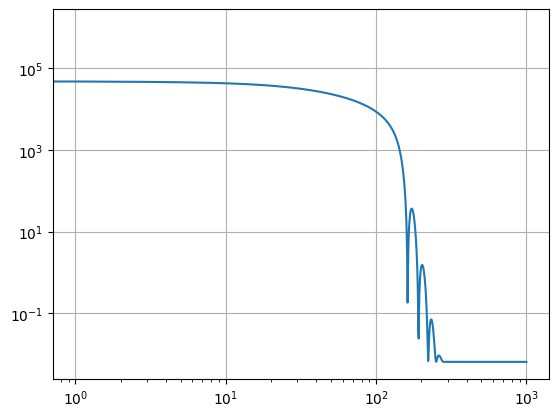

In [36]:
#fig, ax = plt.subplots(1,1)
plt.plot(
    range(1000),
    metrics['mse'],
)
plt.xscale('log')
plt.yscale('log')
plt.grid()